In [1]:
# https://github.com/huggingface/peft/blob/main/examples/sequence_classification/LoRA.ipynb

In [ ]:
!pip install accelerate -U
!pip install transformers datasets evaluate accelerate peft

In [3]:
from google.colab import drive
import pandas as pd
import os
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)

In [4]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp545_FinalProject/code')

from model.train import training_loop
from model.evaluate import evaluate_model
from utils.funcs import load_data, load_tokenizer_model, prepare_dataloader
from utils.plot import plot_confusion_matrix
from utils.test_cases import run_test_cases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Mounted at /content/drive


## Train and evaluate on combine data

In [5]:
train_combine_data_path = "../data_PEFT/lab-manual-combine-train.xlsx"
test_combine_data_path = "../data_PEFT/lab-manual-combine-test.xlsx"

sentences_combine, labels_combine, sentences_test_combine, labels_test_combine = load_data(train_combine_data_path, test_combine_data_path)

In [ ]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_combine, labels_combine, batch_size, device, return_train_dataloader=True)
test_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_test_combine, labels_test_combine, batch_size, device, return_train_dataloader=False)

https://huggingface.co/docs/peft/en/package_reference/lora#peft.LoraConfig
*   task_type: Type of the task (e.g., sequence classification).
*   inference_mode: Whether the model is in inference mode or training mode.
*   r: The rank of the low-rank matrices (defines the number of trainable parameters).
*   lora_alpha: The scaling factor for the LoRA adaptation.
*   lora_dropout: Dropout rate applied to LoRA parameters.
```
if 'lora' in name:
        param.requires_grad = True  # Make LoRA parameters trainable
```
can be used to decide based on parameter names or other criteria which parameters should be trainable.









In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)
peft_type = PeftType.LORA

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_lora = get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()
model_lora
# trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683

In [8]:
optimizer = AdamW(params=model.parameters(), lr=1e-4)
num_epochs = 10
num_training_steps = len(train_val_dataloader_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [9]:
accuracy_list, f1_list = training_loop(model_lora, device, num_epochs, train_val_dataloader_combine, optimizer, lr_scheduler)

100%|██████████| 286/286 [07:30<00:00,  1.57s/it]


Epoch [1/10], Training loss: 0.8818


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [1/10], Validation accuracy:
{'accuracy': 0.670464504820333}
Epoch [1/10], Validation f1:
{'f1': 0.6572905558821824}
---------------------------------------------------


100%|██████████| 286/286 [06:58<00:00,  1.46s/it]


Epoch [2/10], Training loss: 0.4848


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [2/10], Validation accuracy:
{'accuracy': 0.7843996494303243}
Epoch [2/10], Validation f1:
{'f1': 0.7840585834183407}
---------------------------------------------------


100%|██████████| 286/286 [06:57<00:00,  1.46s/it]


Epoch [3/10], Training loss: 0.4673


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [3/10], Validation accuracy:
{'accuracy': 0.8492550394390885}
Epoch [3/10], Validation f1:
{'f1': 0.8495817557216168}
---------------------------------------------------


100%|██████████| 286/286 [06:58<00:00,  1.46s/it]


Epoch [4/10], Training loss: 0.1669


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [4/10], Validation accuracy:
{'accuracy': 0.8983347940403155}
Epoch [4/10], Validation f1:
{'f1': 0.8987378661383119}
---------------------------------------------------


100%|██████████| 286/286 [06:57<00:00,  1.46s/it]


Epoch [5/10], Training loss: 0.0393


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [5/10], Validation accuracy:
{'accuracy': 0.92988606485539}
Epoch [5/10], Validation f1:
{'f1': 0.9297514324975615}
---------------------------------------------------


100%|██████████| 286/286 [06:57<00:00,  1.46s/it]


Epoch [6/10], Training loss: 0.0567


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [6/10], Validation accuracy:
{'accuracy': 0.9404031551270815}
Epoch [6/10], Validation f1:
{'f1': 0.9403519163600957}
---------------------------------------------------


100%|██████████| 286/286 [06:58<00:00,  1.46s/it]


Epoch [7/10], Training loss: 0.0070


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [7/10], Validation accuracy:
{'accuracy': 0.9430324276950044}
Epoch [7/10], Validation f1:
{'f1': 0.9429920274312164}
---------------------------------------------------


100%|██████████| 286/286 [06:58<00:00,  1.46s/it]


Epoch [8/10], Training loss: 0.0028


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [8/10], Validation accuracy:
{'accuracy': 0.9491673970201577}
Epoch [8/10], Validation f1:
{'f1': 0.9491980515884847}
---------------------------------------------------


100%|██████████| 286/286 [06:58<00:00,  1.46s/it]


Epoch [9/10], Training loss: 0.0042


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch [9/10], Validation accuracy:
{'accuracy': 0.9465381244522348}
Epoch [9/10], Validation f1:
{'f1': 0.946500561667445}
---------------------------------------------------


100%|██████████| 286/286 [06:59<00:00,  1.47s/it]


Epoch [10/10], Training loss: 0.0432


100%|██████████| 72/72 [00:52<00:00,  1.38it/s]

Epoch [10/10], Validation accuracy:
{'accuracy': 0.9474145486415425}
Epoch [10/10], Validation f1:
{'f1': 0.9473764534733793}
---------------------------------------------------


In [23]:
accuracy_list

[{'accuracy': 0.670464504820333},
 {'accuracy': 0.7843996494303243},
 {'accuracy': 0.8492550394390885},
 {'accuracy': 0.8983347940403155},
 {'accuracy': 0.92988606485539},
 {'accuracy': 0.9404031551270815},
 {'accuracy': 0.9430324276950044},
 {'accuracy': 0.9491673970201577},
 {'accuracy': 0.9465381244522348},
 {'accuracy': 0.9474145486415425}]

In [24]:
f1_list

[{'f1': 0.6572905558821824},
 {'f1': 0.7840585834183407},
 {'f1': 0.8495817557216168},
 {'f1': 0.8987378661383119},
 {'f1': 0.9297514324975615},
 {'f1': 0.9403519163600957},
 {'f1': 0.9429920274312164},
 {'f1': 0.9491980515884847},
 {'f1': 0.946500561667445},
 {'f1': 0.9473764534733793}]

In [12]:
accuracy, f1, predictions_list, labels_list = evaluate_model(model_lora, test_dataloader_combine, device)

Test accuracy:  {'accuracy': 0.9495798319327731}
Test f1:  {'f1': 0.9496551412379577}


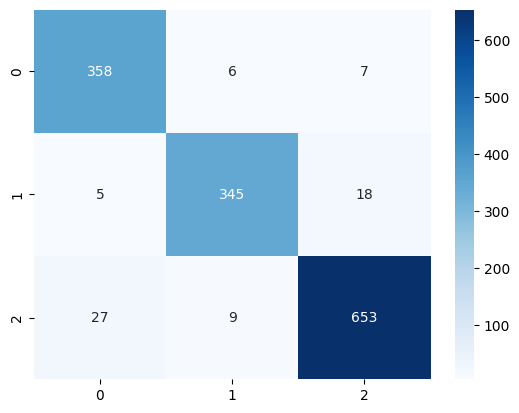

In [13]:
plot_confusion_matrix(labels_list, predictions_list)

In [14]:
# test some cases
lora_model_combinedata_name = 'lora-model-combinedata'
lora_tokenizer_combinedata_name = 'lora-tokenizer-combinedata'

# Save model
tokenizer.save_pretrained(lora_tokenizer_combinedata_name)
model_lora.save_pretrained(lora_model_combinedata_name)

run_test_cases(lora_model_combinedata_name, lora_tokenizer_combinedata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Hawkish
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Dovish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish


## Train and evaluate on split combine  data

In [15]:
train_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-train.xlsx"
test_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-test.xlsx"

sentences_split_combine, labels_split_combine, sentences_test_split_combine, labels_test_split_combine = load_data(train_split_combine_data_path,
                                                                                                                   test_split_combine_data_path)

In [ ]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                        sentences_split_combine,
                                                        labels_split_combine,
                                                        batch_size,
                                                        device,
                                                        return_train_dataloader=True)
test_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                   sentences_test_split_combine,
                                                   labels_test_split_combine,
                                                   batch_size,
                                                   device,
                                                   return_train_dataloader=False)

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)
peft_type = PeftType.LORA

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_lora = get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()
model_lora
# trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683

In [20]:
optimizer = AdamW(params=model.parameters(), lr=1e-4)
num_epochs = 10
num_training_steps = len(train_val_dataloader_split_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_split_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [25]:
accuracy_list_splitdata, f1_list_splitdata = training_loop(model_lora,
                                                           device,
                                                           num_epochs,
                                                           train_val_dataloader_split_combine,
                                                           optimizer,
                                                           lr_scheduler)

100%|██████████| 298/298 [07:54<00:00,  1.59s/it]


Epoch [1/10], Training loss: 1.0729


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [1/10], Validation accuracy:
{'accuracy': 0.6747899159663866}
Epoch [1/10], Validation f1:
{'f1': 0.6592883910745359}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [2/10], Training loss: 0.8904


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [2/10], Validation accuracy:
{'accuracy': 0.7697478991596639}
Epoch [2/10], Validation f1:
{'f1': 0.7659353964267}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [3/10], Training loss: 0.2075


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [3/10], Validation accuracy:
{'accuracy': 0.865546218487395}
Epoch [3/10], Validation f1:
{'f1': 0.8652691800224354}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [4/10], Training loss: 0.2439


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [4/10], Validation accuracy:
{'accuracy': 0.9319327731092437}
Epoch [4/10], Validation f1:
{'f1': 0.9321113810371625}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [5/10], Training loss: 0.0224


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [5/10], Validation accuracy:
{'accuracy': 0.9605042016806723}
Epoch [5/10], Validation f1:
{'f1': 0.960494467350163}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [6/10], Training loss: 0.0059


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [6/10], Validation accuracy:
{'accuracy': 0.9705882352941176}
Epoch [6/10], Validation f1:
{'f1': 0.970573787137673}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [7/10], Training loss: 0.3443


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [7/10], Validation accuracy:
{'accuracy': 0.9764705882352941}
Epoch [7/10], Validation f1:
{'f1': 0.9764686575651207}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [8/10], Training loss: 0.0022


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [8/10], Validation accuracy:
{'accuracy': 0.9747899159663865}
Epoch [8/10], Validation f1:
{'f1': 0.9747820943311669}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [9/10], Training loss: 0.0021


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [9/10], Validation accuracy:
{'accuracy': 0.9773109243697479}
Epoch [9/10], Validation f1:
{'f1': 0.9773070327799965}
---------------------------------------------------


100%|██████████| 298/298 [07:15<00:00,  1.46s/it]


Epoch [10/10], Training loss: 0.0036


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]

Epoch [10/10], Validation accuracy:
{'accuracy': 0.9747899159663865}
Epoch [10/10], Validation f1:
{'f1': 0.9747803543510529}
---------------------------------------------------


In [26]:
accuracy_list_splitdata

[{'accuracy': 0.6747899159663866},
 {'accuracy': 0.7697478991596639},
 {'accuracy': 0.865546218487395},
 {'accuracy': 0.9319327731092437},
 {'accuracy': 0.9605042016806723},
 {'accuracy': 0.9705882352941176},
 {'accuracy': 0.9764705882352941},
 {'accuracy': 0.9747899159663865},
 {'accuracy': 0.9773109243697479},
 {'accuracy': 0.9747899159663865}]

In [27]:
f1_list_splitdata

[{'f1': 0.6592883910745359},
 {'f1': 0.7659353964267},
 {'f1': 0.8652691800224354},
 {'f1': 0.9321113810371625},
 {'f1': 0.960494467350163},
 {'f1': 0.970573787137673},
 {'f1': 0.9764686575651207},
 {'f1': 0.9747820943311669},
 {'f1': 0.9773070327799965},
 {'f1': 0.9747803543510529}]

In [29]:
accuracy_splitdata, f1_splitdata, predictions_list_splitdata, labels_list_splitdata = evaluate_model(model_lora,
                                                                                                     test_dataloader_split_combine,
                                                                                                     device)

Test accuracy:  {'accuracy': 0.9684139784946236}
Test f1:  {'f1': 0.9684131900906677}


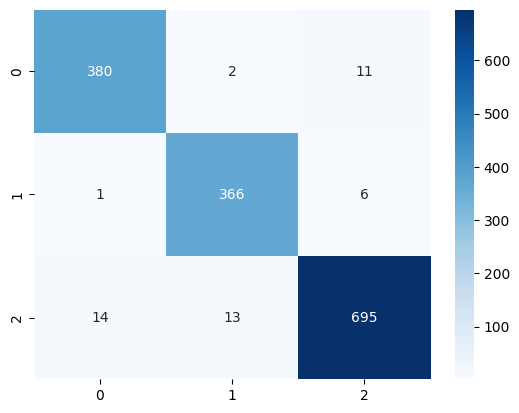

In [30]:
plot_confusion_matrix(labels_list_splitdata, predictions_list_splitdata)

In [31]:
# test some cases
lora_model_splitdata_name = 'lora-model-splitdata'
lora_tokenizer_splitdata_name = 'lora-tokenizer-splitdata'

# Save model
tokenizer.save_pretrained(lora_tokenizer_splitdata_name)
model_lora.save_pretrained(lora_model_splitdata_name)

run_test_cases(lora_model_splitdata_name, lora_tokenizer_splitdata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Hawkish
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Dovish
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Hawkish
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish
